# Videogame newsletter subscription based on predictors age and hours played: analysis with a k-Nearest-Neighbours classification model

__Names and Student Numbers__

Gaureka Khurana (58228743) <br>
Simon Shiming Zhao (74929902) <br>
Wuzhou Wang(89637383) <br>
Chloe Ngo (92230929) <br>

## Introduction:

### Background:
In game development, it is critical for marketers and game developers to understand what motivates players so that they can shape their marketing and development processes. Perhaps the most critical area of concern is understanding why some players choose to subscribe to newsletters and others don't. Newsletters are important since they remind subscribers about new games, updates, events, and promotions, which might make them more active and loyal. To analyze this, we take into consideration two main factors: the age of the players (age) and how long they play (hours played). The player's age could define their interests and the type of content they like, while hours played represents how much effort they put into the game. By examining these elements, we can try to predict who is going to subscribe to more information through newsletters. This project uses information from an internet gaming website that gives information on the player's age, amount of time playing, and subscription to the newsletter. By examining this information, we hope to observe the trends and learn something that can help make more effective means of communication.

### Question: 
**How do age and hours played influence a player’s decision to subscribe to a newsletter?**

## Data Description

### Players Dataset 

The `players.csv` dataset includes **196** players across **7** variables, some including experience, hours_played etc

| Variable | Type | Description |
|----------|------|-------------|
| `experience` | Categorical (character) | Player's skill level  |
| `subscribe` | Boolean (logical) | Whether the player subscribed to the newsletter. |
| `hashedEmail` | String (character) | Unique identifier |
| `played_hours` | Numeric (double) | Total hours played. |
| `name` | String (character) | Player’s name. |
| `gender` | Categorical (character) | Player’s gender. |
| `Age` | Integer | Player’s age. |

#### Summary Statistics


| Variable      | Range         | Mean  | Median | 1st Quartile | 3rd Quartile | Outliers          | Missing Values |
|---------------|---------------|-------|--------|--------------|--------------|-------------------|----------------|
| Played Hours  | 0 to 223.1    | 5.846 | 0.1    | 0            | 0.6          | High mean         | None           |
| Age (years)   | 8 to 50       | 20.52 | 19     | 17           | 22           | Above 29.5        | 2              |


**Experience**
- **Amateur**: 63 
- **Beginner**: 35 
- **Pro**: 14 
- **Regular**: 36 
- **Veteran**: 48 

**Subscription**
- **Subscribed**: 144 
- **Not-Subscribed**: 52 

### Sessions Dataset 

The `sessions.csv` dataset includes **1535** gaming sessions with **5** variables, some including start and end_times etc.  

| Variable             | Type                | Description                                          |
|----------------------|---------------------------------|------------------------------------------------------|
| `hashedEmail`        | String (character)  | Unique identifier for each player |
| `start_time`         | String (character)  | Start time of the session |
| `end_time`           | String (character)  | End time of the session |
| `original_start_time`| Numeric (double)    | Unix timestamp of the session start time.             |
| `original_end_time`  | Numeric (double)    | Unix timestamp of the session end time.               |

#### Summary_Statistics

`original_start_time` and `original_end_time`
- **Range**: 1.727e+12 - 1.712e+12
- **1st and 3rd Quartile**: 1.716e+12 and 1.722e+12 respectively
- **Median**: 1.719e+12
- **Mean**: 1.719e+12
- **Missing_Values**: 2 **ONLY** for `original_end_time`

### Potential Issues
- **Missing Data:** Age (2), original_end_time (2).
-  **Outliers:** High played_hours may skew results.
- **Bias:** More subscribed players.
- **Limited_Information:** No game type or goals.
- **Idle_Sessions:** May include inactivity.

### Data Collection
- `players.csv` could be collected using player registration forms or gameplay monitoring systems.
- `sessions.csv` Automatically logged by the game server.

### Unnecessary Variables
- name
- hashedEmail

The data was collected to analyze player engagement, track session activity, and improve engagement strategies.

## Methods:

#### Loading Libraries
For classification and data analysis, certain libraries are necessary.

In [9]:
#Setting the seed for reproducible code
set.seed(303)
#Loading Libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(digest)
library(infer)
library(gridExtra)

#### Reading the datasets
The two datasets are both comma seperated files.

In [10]:
#Reading the Sessions dataset
url_sessions <- "https://raw.githubusercontent.com/cngo05/Data-sci-100-group-20/refs/heads/main/sessions.csv"
sessions <- read_csv(url_sessions)
head(sessions)
#Reading the Players dataset
url_players <- "https://raw.githubusercontent.com/cngo05/Data-sci-100-group-20/refs/heads/main/players.csv"
players <- read_csv(url_players)
head(players)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail                                                     
1 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3 f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
4 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
5 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
6 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
  start_time       end_time         original_start_time original_end_time
1 30/06/2024 18:12 30/06/2024 18:24 1.71977e+12         1.71977e+12      
2 17/06/2024 23:33 17/06/2024 23:46 1.71867e+12         1.71867e+12      
3 25/07/2024 17:34 25/07/2024 17:57 1.72193e+12         1.72193e+12      
4 25/07/2024 03:22 25/07/2024 03:58 1.72188e+12         1.72188e+12      
5 25/05/2024 16:01 25/05/2024 16:12 1.71665e+12         1.71665e+12      
6 23/06/2024 15:08 23/06/2024 17:10 1.71916e+12         1.71916e+12

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1 Pro         TRUE    
2 Veteran     TRUE    
3 Veteran    FALSE    
4 Amateur     TRUE    
5 Regular     TRUE    
6 Amateur     TRUE    
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender Age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

__Tables 1.1 and 1.2: First 6 observations from the original Sessions and Players Dataset__

#### Cleaning and Wrangling the Data
Looking for any NA unknown values in the dataset:

In [11]:
#Filtering off any NA observations
filtered_na_players <- players |>
    filter(hashedEmail != "NA",
           subscribe != "NA",
           experience != "NA",
           played_hours != "NA",
           name != "NA",
           gender != "NA",
           Age != "NA"
          )
filtered_na_sessions <- sessions |>
    filter(hashedEmail != "NA",
           start_time != "NA",
           end_time != "NA",
           original_start_time != "NA",
           original_end_time != "NA",
           )
tail(filtered_na_players)
tail(filtered_na_sessions)

experience subscribe
1 Amateur    FALSE    
2 Amateur     TRUE    
3 Amateur     TRUE    
4 Veteran    FALSE    
5 Amateur    FALSE    
6 Amateur    FALSE    
  hashedEmail                                                      played_hours
1 514ebbaa30f0d162127e065ab780892b7930cf8d75944d5eb09c91c02d6026c7 0.0         
2 644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6 0.0         
3 b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f 0.0         
4 71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd 0.3         
5 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb 0.0         
6 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436 2.3         
  name   gender            Age
1 Orion  Male              17 
2 Rhys   Male              20 
3 Bailey Female            17 
4 Pascal Male              22 
5 Dylan  Prefer not to say 17 
6 Harlow Male              17

hashedEmail                                                     
1 b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319
2 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3 7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875
4 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
5 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
6 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
  start_time       end_time         original_start_time original_end_time
1 28/08/2024 23:31 29/08/2024 00:15 1.72489e+12         1.72489e+12      
2 10/05/2024 23:01 10/05/2024 23:07 1.71538e+12         1.71538e+12      
3 01/07/2024 04:08 01/07/2024 04:19 1.71981e+12         1.71981e+12      
4 28/07/2024 15:36 28/07/2024 15:57 1.72218e+12         1.72218e+12      
5 25/07/2024 06:15 25/07/2024 06:22 1.72189e+12         1.72189e+12      
6 20/05/2024 02:26 20/05/2024 02:45 1.71617e+12         1.71617e+12

__Tables 2.1 and 2.2: Last 6 observations from filtered Players and Sessions datasets__


Since this analysis aims to use KNN classification to determine whether or not a player subscribes, the Sessions data does not appear to be useful in giving predictors and do not contain observations that are traceble to the subscribe class. Thus only the Players dataset will be further discussed. <br>
Additionally, KNN classification will be performed using only quantitative variables as predictors, thus the qualitative variables `experience`, `hashedEmail`, `name`, `gender` are to be removed. Leaving the quantitative variables `Age`, `played_hours`, as well as the class variable `subscribe`. <br>
To prepare for classification, the class variable `subscribe` is mutated to be a factor instead of a logical data type.

In [12]:
clean_players <- filtered_na_players |>
    #Mutating subscribe to be a factor
    mutate(Subscribe = as_factor(subscribe)) |>
    #Selecting quantitative columns and the class variable
    select(Subscribe, played_hours, Age) 
tail(clean_players)

Subscribe played_hours Age
1 FALSE     0.0          17 
2 TRUE      0.0          20 
3 TRUE      0.0          17 
4 FALSE     0.3          22 
5 FALSE     0.0          17 
6 FALSE     2.3          17

__Table 3: Cleaned Players dataset with only necessary columns (quantitative and class)__

#### Summary of the Players dataset
To gain a better understanding of the dataset at hand, summary statistics are calculated on the quantitative variables in Players:

In [13]:
summary_players <- clean_players |>
    #Calculating summary statistics
    summarize(median_played_hours = median(played_hours),
                mean_played_hours = mean(played_hours),
                mean_age = mean(Age),
                median_age = median(Age),
                max_played_hours = max(played_hours),
                min_played_hours = min(played_hours),
                max_age = max(Age),
                min_age = min(Age),
                q1_age = quantile(Age, 0.25),
                q3_age = quantile(Age, 0.75),
                q1_played_hours = quantile(played_hours, 0.25),
                q3_played_hours = quantile(played_hours, 0.75)
                )  |>
    #making the summary values easier to read
    pivot_longer(cols = median_played_hours:q3_played_hours,
                names_to = "Statistic", 
                values_to = "Value")
summary_players 

Statistic           Value     
1  median_played_hours   0.100000
2  mean_played_hours     5.904639
3  mean_age             20.520619
4  median_age           19.000000
5  max_played_hours    223.100000
6  min_played_hours      0.000000
7  max_age              50.000000
8  min_age               8.000000
9  q1_age               17.000000
10 q3_age               22.000000
11 q1_played_hours       0.000000
12 q3_played_hours       0.600000

__Table 4: Summary of the clean Players dataset__

By inspection, the number of hours played appears to be clustered heavily around lower values, with the middle 50% of the data lying between 0 and 0.6 hours. There are also high maximum values in `Age` and `played_hours` and the mean is greater than the median in both variables, suggesting a right-skewed distribution.

#### Visualization of the Players dataset
The quantitative variables of the Players dataset are preliminarily visualized with a scatter plot. Colour denotes the `Subscribe` class.

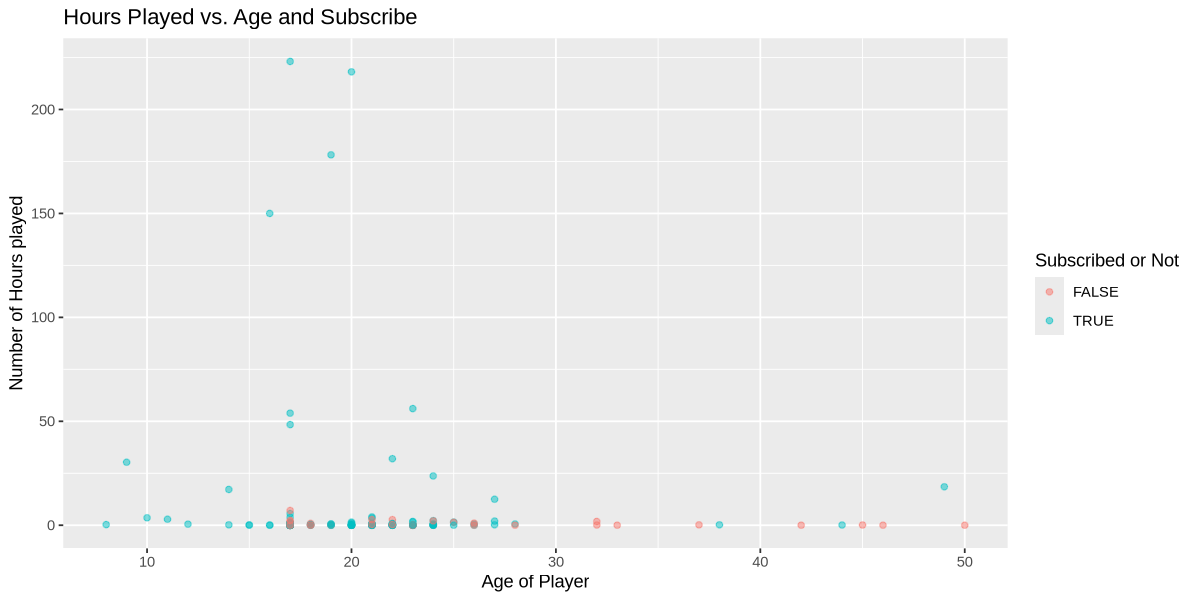

In [14]:
#Making the plot size more reasonable
options(repr.plot.width= 10, repr.plot.height=5)
#Using ggplot2 to create scatterplot
exploratory_plot <- clean_players |>
    ggplot(aes(x = Age, y = played_hours, color = Subscribe)) +
    geom_point(alpha=0.5) +
    labs(x = "Age of Player", y = "Number of Hours played", color = "Subscribed or Not") +
    ggtitle("Hours Played vs. Age and Subscribe")
exploratory_plot

__Figure 1: Scatterplot between hours played and the age of player, colour denoting subscription class__

There appears to be a weak negative relationship between hours played and age. From visual inspection alone, it looks like as age of player decreases and hours played increases, subjects were more likely to be subscribed.

#### Data Analysis
To evaluate the effectiveness of the classifcation algorithm at the end, a testing set is required. <br>
Splitting the data 75% training and 25% testing, not leaking the testing set until the end of analysis:

In [15]:
#setting the seed for reproducibility
set.seed(303)
#splitting the data 75 to 25
players_split <- initial_split(clean_players, prop = 0.75, strata = Subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

A recipe is made with the only two numerical variables as predictors. The data is also preprocessed by scaling and centering, such that one variable would not have more influence in the algorithm than the other.

In [16]:
#Creating recipe
players_recipe <- recipe(Subscribe ~ played_hours + Age, data = players_train) |>
    #Centering and scaling
    step_scale(all_predictors()) |>
    step_center(all_predictors())

A KNN model and workflow are created and cross validation is used on the entire dataset to tune for the optimal value of `k` (number of nearest neighbours) for classifying this dataset. The different values and their effectivenes are determined via a line graph.

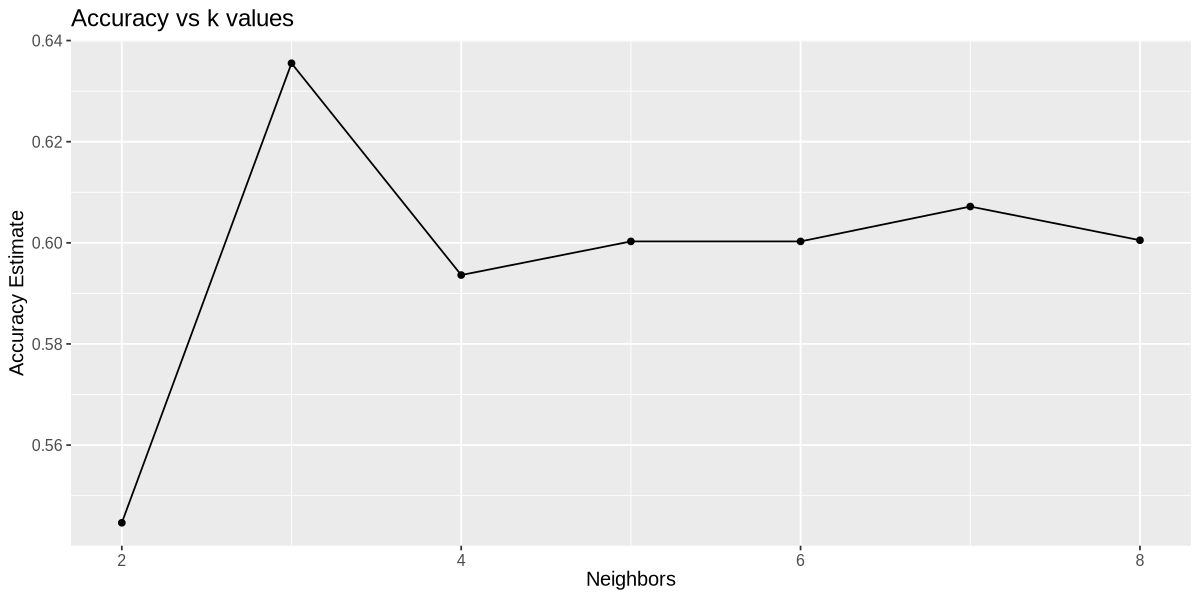

In [17]:
#Setting the seed for reproducibility
set.seed(303)
#Creating a KNN model, setting the number of neighbours to tune()
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
#Values of k to be tested
k_vals <- tibble(neighbors  = c(2, 3, 4, 5, 6, 7, 8))
#Setting cross validation to 5 fold.
numbers_vfold <- vfold_cv(players_train, v = 5, strata = Subscribe)
#Creating a workflow
knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = numbers_vfold, grid = k_vals) |>
    collect_metrics()
#Obtaining the accuracies for different k values
accuracies <-knn_fit |>
    filter(.metric == "accuracy")
#Line plot of k value accuracy
cross_validation_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12)) +
    ggtitle("Accuracy vs k values")
cross_validation_plot


__Figure 2: Line plot of Accuracy estimate varying with the number of neighbours__

From the above plot, it appears that accuracy is highest when k = 3 and drops down afterwards. Thus 3 nearest neighbours are used in training the final classification algorithm.

In [18]:
#Setting the seed for reproduciblity
set.seed(303)
#KNN model with the optimal k = 3 neighbours
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")
#Fitting the model into a workflow
players_fit <-  workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

Finally, the model may be evaluated by predicting on the testing set. 

In [19]:
#Setting the seed for reproduciblity
set.seed(303)
#Predicting on the testing set
players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)
tail(players_predictions)

.pred_class Subscribe played_hours Age
1 FALSE       FALSE     1.8          32 
2 FALSE       FALSE     0.0          50 
3 TRUE        FALSE     2.7          21 
4 TRUE        TRUE      0.4          17 
5 FALSE       TRUE      0.1          44 
6 FALSE       TRUE      0.0          17

__Table 5: Last 6 values of predictions on `players_test`__

Reporting the accuracy and the results of the test with a confusion matrix:

In [20]:
#Obtaining test set performance metrics
players_metrics <- players_predictions |>
    metrics(truth = Subscribe , estimate = .pred_class) 
players_metrics
#Turning the metrics into a confusion matrix
players_confusion_matrix <- players_predictions |>
    conf_mat(truth = Subscribe , estimate = .pred_class)
players_confusion_matrix

.metric  .estimator .estimate 
1 accuracy binary      0.4693878
2 kap      binary     -0.0127186

          Truth
Prediction FALSE TRUE
     FALSE     7   20
     TRUE      6   16

__Table 6.1 and 6.2:  Metrics of the classification model and its confusion matrix__

Visualizing the classification model's decision making process with a colour prediction map that shows the decision boundary:

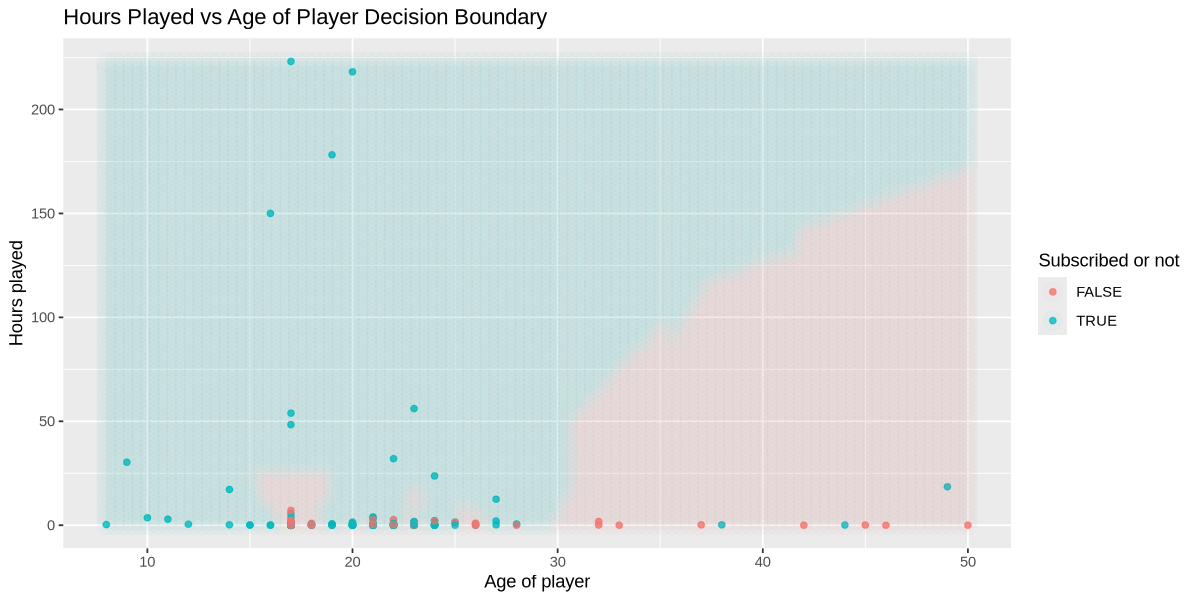

In [21]:
#Creating grid of area and smoothness values, arranged in a data frame
area_grid <- seq(min(clean_players$Age),
                max(clean_players$Age),
                length.out = 100)
smooth_grid <- seq(min(clean_players$played_hours),
                max(clean_players$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Age = area_grid,
                                played_hours = smooth_grid))
#Workflow to predict at the area grid values
knn_grid <- predict(players_fit, asgrid)
#Predicted values bound to a new column
prediction_table <- bind_cols(knn_grid, asgrid) |>
  rename(Class = .pred_class)
#Creating scatterplots with original data points and fine, scattered background points
options(repr.plot.width= 10, repr.plot.height=5)
players_boundary_plot <-ggplot() +
  geom_point(data = clean_players,
             mapping = aes(x = Age, y = played_hours, color = Subscribe),
             alpha = 0.80) +
  geom_point(data = prediction_table, mapping = aes(x = Age, y = played_hours, color = Class), alpha = 0.02,
             size = 5) +
  labs(color = "Subscribed or not",
       x = "Age of player",
       y = "Hours played") + ggtitle("Hours Played vs Age of Player Decision Boundary")
players_boundary_plot

__Figure 3: Coloured prediction map illustrating decision boundary of KNN classifier__

## Results

#### Short introduction of Methods
According to the Method shown above, we first need to clear the data in the .csv file and then remove the observations that contain NA values, which clears the data, making it clearer for the computer to process. Then, we make a large table to summarize the necessary data. After this process, we decided to choose two factors to determine the question: whether age and hours played influence a player’s decision to subscribe to a newsletter. We will soon use these two variables, namely the age of players and the hours they play, to determine the relationship between them and whether players are likely to subscribe to the newsletter.

#### What did we do in the Method part?
To analyze the results of the Method, we chose to use k-nearest neighbor classification (kNN) to determine the relationship. To achieve greater accuracy, we decided to use Cross-Validation to determine the best K value for classification. We use five-fold cross-validation to detect it. After several processes, we can draw the graph, as shown in Figure 2, to determine that the optimal k-value is 3. Then, to use the optimal k-value for kNN, draw a graph that represents the possible subscription range.

#### The Results
The graph shows that the greater the number of hours players spent playing, the more likely they are to subscribe to the newsletter, and it appears that the age of players also influences this. People who are older may be less likely to subscribe to the newsletter, but activities that elders may not spend much time on, such as playing, could impact the results and lead to some errors.

## Discussion

#### Findings
Our visualizations revealed that there was a (weak) relationship between hours played and the age of the player. As the Age of player decreased we found that there was a increase of hours played. Although the majority of hours played were condensed at below 50 hours the outliers were found in younger ages. Using our classfication model and colour prediction plot the majority of subscribed users are younger and play more hours.
This is expected as younger individuals are generally expected to have more free time and play video games more than employed adults. It makes sense that players subscribed to the newsletter would be people who play more hours.

#### Impact our findings could have?
This could help developers find their target market, if they would like to get more subsciptions they can develop marketing that increases the number of younger players to subscribe or develop a new strategie to target the older playerss
#### Future Questions 

## Conclusion

This study explored the relationship between player age and hours played, and their likelihood to subscribe to a gaming newsletter. Using a K-nearest neighbors model, we found that these factors indeed influence subscription decisions, particularly among younger and less active players. Despite some predictive limitations, our findings suggest targeting marketing strategies based on these characteristics could improve engagement. Future improvements could include adding more variables to enhance the model's accuracy.

